In [54]:
%run Function_set_gurobi.ipynb

import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt
import json
import os
from tqdm.notebook import tqdm

In [55]:
from collections import defaultdict

import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import*
from gurobipy import quicksum

In [56]:
def constraint_1(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_matched = []
    
    for vertex_selected in index:
            
        #print(int(compelete_label[(vertex, vertex_selected)]))
        
            index_matched.append( int(compelete_label[(vertex, vertex_selected)]) )
    
    return index_matched

In [57]:
def constraint_2(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index_out = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_out_matched = []
    
    for vertex_selected in index_out:
            
        index_out_matched.append( int(compelete_label[(vertex, vertex_selected)])  )
    
    index_in = np.hstack(np.asarray(np.where(Final_map[:,vertex])))
    
    index_in_matched = []
    
    for vertex_selected in index_in:
        index_in_matched.append( int(compelete_label[(vertex_selected, vertex )])  )

    
    return index_out_matched, index_in_matched

In [58]:
%run Function_set_gurobi.ipynb
def test(network,pos):
    G, compelete_label, graph = complete_Graph(network,pos)
    G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)
    
    # How many panel ---> Max electricity level wire could reach 
    Q = len(pos)-1
    
    # How many edges
    edge_number = len(compelete_label)


    # basic_cost shape => (1,number_of_edge)
    # such as : basic_cost = np.vstack(np.ones(number_of_edge))
    # test case : #basic_cost = np.arange(edge_number)

    basic_cost = np.ones(edge_number) * 2


    # flow cost (p)
    flow_cost = np.ones(edge_number) 
    p = 1


    # make dictionary
    edge_dictionary, Total = make_dictionary(edge_number, Q)

    # initialize a QUBO matrix needed
    QUBO_matrix_initial = np.zeros((Total, Total))
    
    c_e = (np.tile(np.vstack(basic_cost),(1,Q+1)))
        
    level_coeff = (np.tile(np.arange(1,Q + 1),(edge_number,1))).flatten()
    
    
    m_t_u = np.zeros(Q)
    m_t_l = np.zeros(Q)
    #m_t_l[3] = 1
    m_t_l[2] = 1
    m_t_u[:] = 3
    
    
    try:

        # Create a new model
        m = gp.Model("Solar_panel_old_model")
        m.Params.LogToConsole = 0

        # Create variables
        x = m.addVars(edge_number, Q, vtype=GRB.BINARY, name="x")

        #print(x)
        # Set objective
        
        m.setObjective( quicksum(quicksum((p * j) * c_e[i,j]  * x[i,j] for i in range(Q , edge_number)) for j in range(Q))
                       + quicksum(quicksum(c_e[i,j]  * x[i,j] for i in range(edge_number)) for j in range(Q)) , GRB.MAXIMIZE)
    

        # Add constraint 1:
        for vertex in range(1, Q + 1):

            index = constraint_1(network, Q, edge_dictionary, compelete_label, vertex)

            # 
            m.addConstr(quicksum( quicksum(x[i,j] for j in range(Q)) for i in index) == 1, name=f'constraint_1_vertex_{vertex}')

        # Add constraint 2:  
        for vertex in range(1, Q + 1):

            index_out, index_in = constraint_2(network, Q, edge_dictionary, compelete_label, vertex)

            #print(index_out, index_in, level_coeff[index_in])

            m.addConstr( quicksum(quicksum( (j+1) * x[i,j] for j in range(Q)) for i in index_out) - quicksum( quicksum( (n+1) * x[m,n] for n in range(Q)) for m in index_in)  == 1, name=f'constraint_2_vertex_{vertex}')

        # Add constraint 3:
        for level in range(Q):

            m.addConstr( quicksum( x[m,level] for m in range(Q)) <= m_t_u [level], name=f'constraint_3_rhs_{level}')
            m.addConstr( quicksum( x[m,level] for m in range(Q)) >= m_t_l [level], name=f'constraint_3_lhs_{level}')

        # Optimize model
        m.optimize()
        #print (m.display())
        
        time = m.Runtime
        
        print(time)

        x_list = [str.replace(str.replace(v.varName,"]",""),"x[","") for v in m.getVars() if v.x == 1 and v.varName[0] =='x']

        #print('Obj: %g' % m.objVal)
        
        
        print("Gurobi runtime is", m.Runtime ,"seconds")
        
        plt.figure(5)
        final_G = nx.DiGraph()
        final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

        #print(str(final_index // Q))
        #print(str(final_index % Q))

        for item in x_list:
            #print(item)

            index, level = item.split(',')

            #print(index, int(level) + 1)

            final_G.add_weighted_edges_from([(*edge, int(level)+1)  for edge, label in compelete_label.items() if label == index ])




        matfig = plt.figure(figsize=(10,10)) 
        labels = nx.get_edge_attributes(final_G,'weight')
        widths = list(nx.get_edge_attributes(final_G,'weight').values())
        print("widths",widths)
        nx.draw_networkx(final_G, pos)
        nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
        nx.draw_networkx_edges(final_G,pos,width = widths)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    
    return time


F:\UoH\UoH_code\Minimum Spanning Tree\Gurobi\W4_H3_Benchmark
0.0220184326171875
Gurobi runtime is 0.0220184326171875 seconds
widths [2, 3, 1, 2, 1, 4, 3, 5]


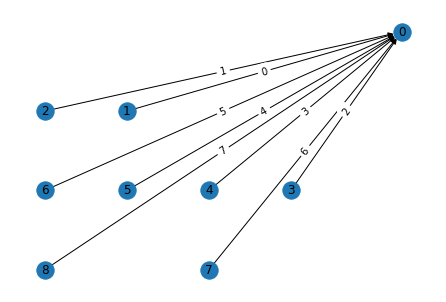

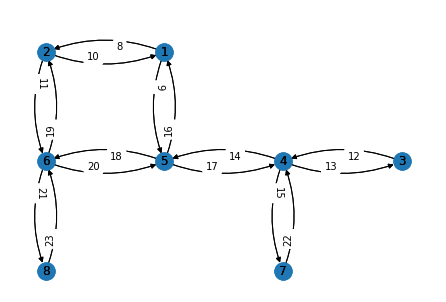

<Figure size 432x288 with 0 Axes>

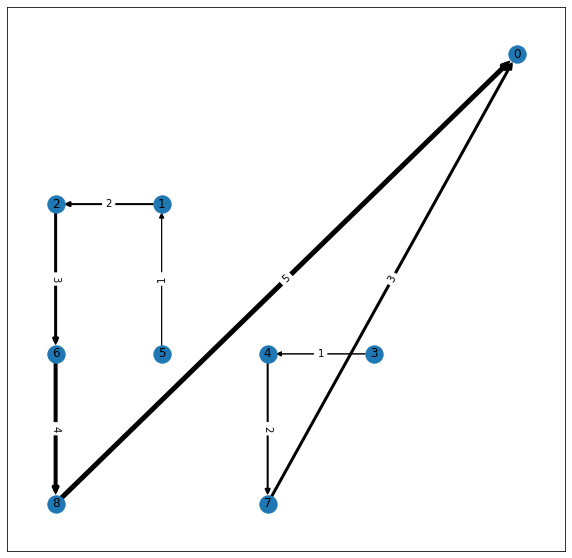

In [59]:
import time

bench_num = 10

Width = 4
Height = 3


current_directory = os.getcwd()
    
next_dir = "W%d_H%d_Benchmark"%(Width, Height)
    
final_directory = os.path.join(current_directory, next_dir)

time_list = np.zeros(bench_num)
    
print(final_directory)
    
if not os.path.exists(final_directory):
    os.makedirs(final_directory)


#for i in tqdm(range(bench_num)):  
#for i in tqdm(range(1)):  
i = 0

network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))
    
with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
    data = json.load(f)
    pos_convert = json.loads(data)
        
pos = {}
    
for key in pos_convert.keys():
    pos[int(key)] = tuple(pos_convert[key])

    
time_test = test(network,pos)
    
time_list[i] = time_test
      

In [60]:
print(np.mean(time_list))

0.00220184326171875


In [61]:
#time_list

0.02352142333984375
Gurobi runtime is 0.02352142333984375 seconds
widths [2, 3, 1, 2, 1, 4, 3, 5]
0.03903388977050781
Gurobi runtime is 0.03903388977050781 seconds
widths [4, 3, 5, 2, 3, 2, 1, 1]
0.022520065307617188
Gurobi runtime is 0.022520065307617188 seconds
widths [2, 3, 1, 2, 1, 4, 3, 5]
0.0220184326171875
Gurobi runtime is 0.0220184326171875 seconds
widths [2, 3, 1, 2, 1, 4, 3, 5]
0.04303741455078125
Gurobi runtime is 0.04303741455078125 seconds
widths [5, 3, 2, 4, 3, 1, 1, 1]
0.042034149169921875
Gurobi runtime is 0.042034149169921875 seconds
widths [5, 4, 1, 1, 2, 3, 2, 3]
0.03703117370605469
Gurobi runtime is 0.03703117370605469 seconds
widths [2, 1, 1, 3, 3, 2, 5, 4]
0.04553985595703125
Gurobi runtime is 0.04553985595703125 seconds
widths [5, 3, 2, 4, 3, 1, 1, 1]
0.026521682739257812
Gurobi runtime is 0.026521682739257812 seconds
widths [3, 2, 3, 2, 1, 5, 4, 1]
0.024021148681640625
Gurobi runtime is 0.024021148681640625 seconds
widths [2, 1, 2, 1, 3, 3, 4, 1]

0.03252792358

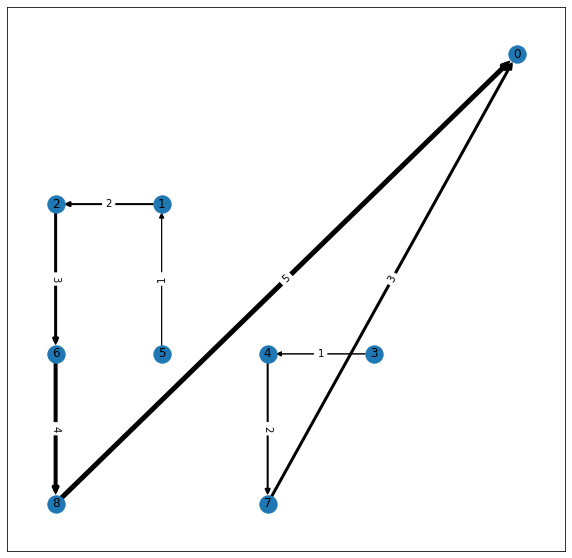

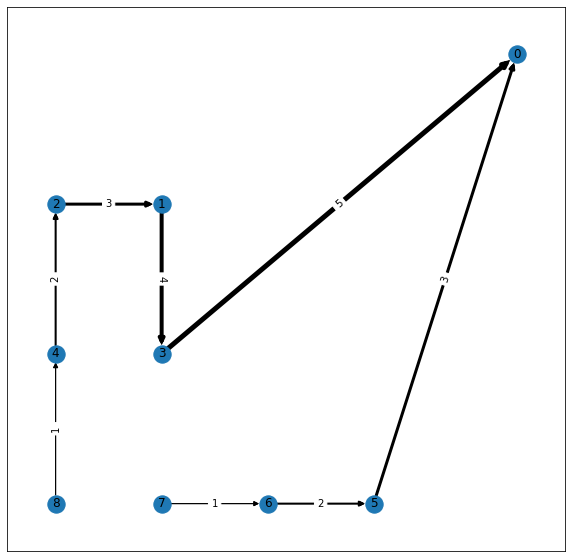

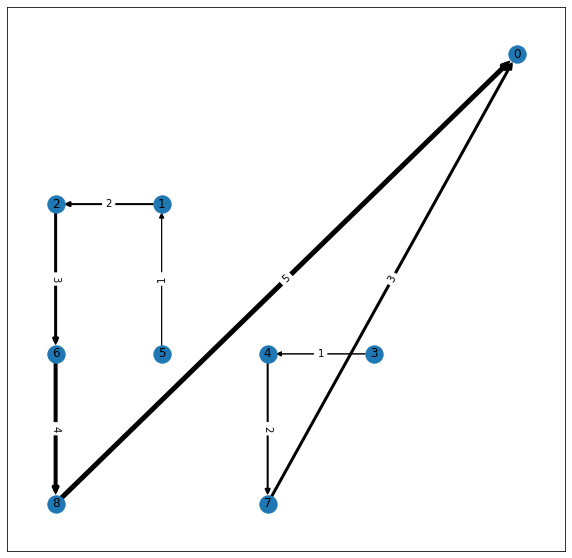

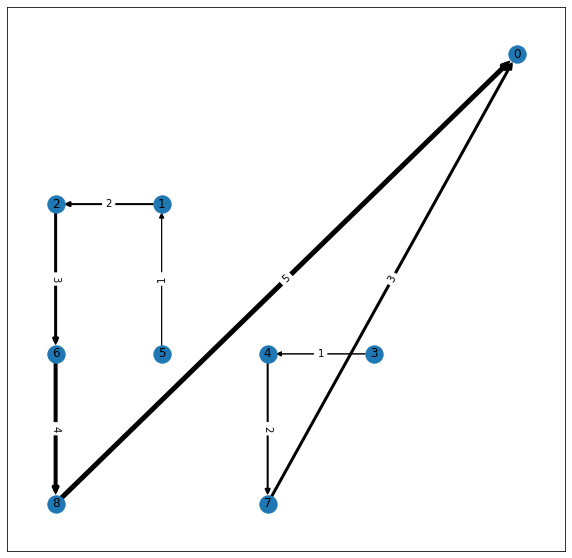

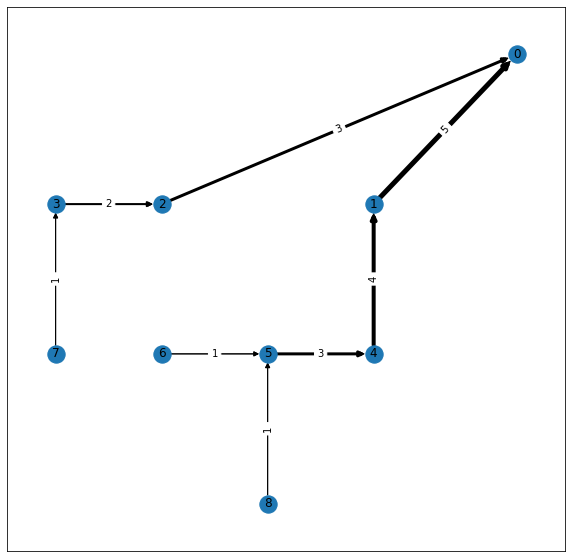

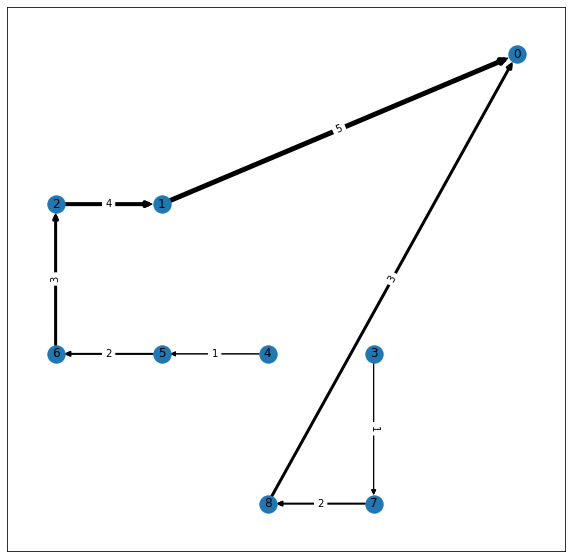

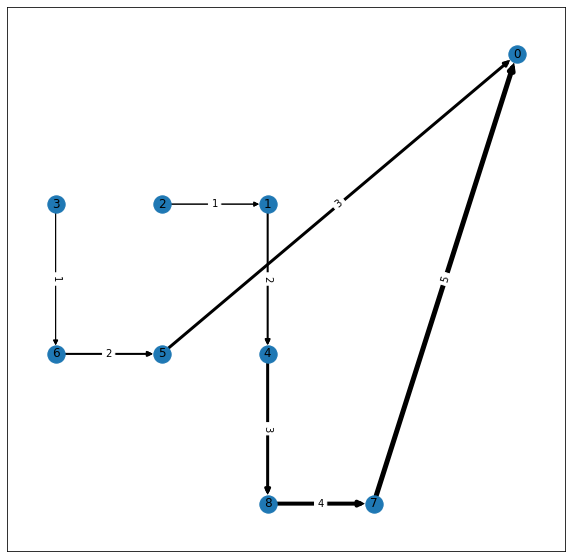

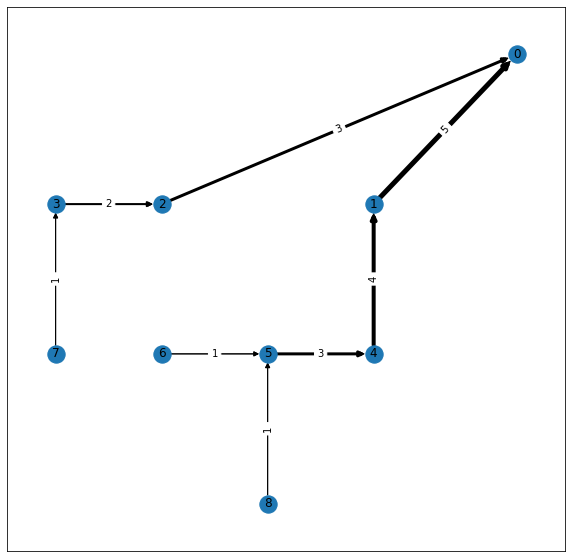

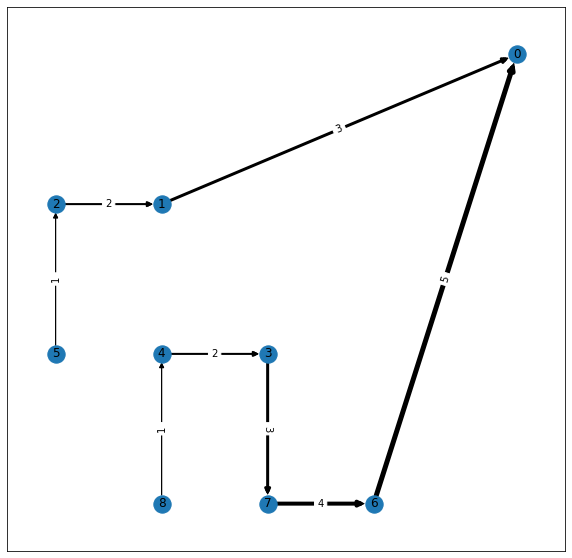

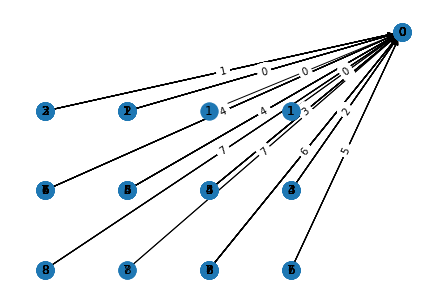

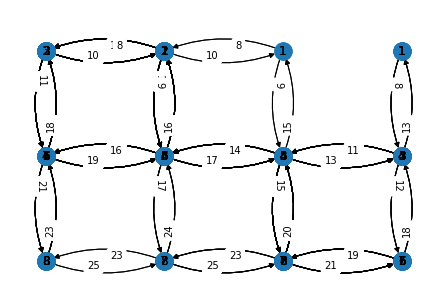

<Figure size 432x288 with 0 Axes>

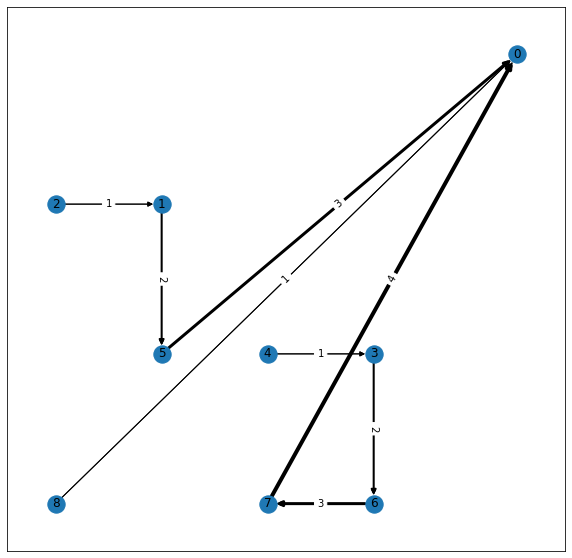

In [67]:
for i in tqdm(range(bench_num)):  
    #for i in tqdm(range(1)):  

    network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))

    with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
        data = json.load(f)
        pos_convert = json.loads(data)

    pos = {}

    for key in pos_convert.keys():
        pos[int(key)] = tuple(pos_convert[key])


    time_test = test(network,pos)

    time_list[i] = time_test
    
print(np.mean(time_list))